In [55]:
from imports import *
from datasets.bdd_oia import BDD_OIA

In [56]:
image_home = './data/bdd_oia/lastframe/data/'
label_home = './data/bdd_oia/lastframe/labels/'


In [57]:
# labels = pd.read_csv(label_home+'no_train.csv')
labels = pd.read_pickle(label_home+'no_train.pkl')
labels.head(3)

,file_name,reason,action,reason_lang,reason_lang_ind
2075,b82609d8-eef37c99_3.jpg,"[0, 1, 0, 1, 0, 0]","[1, 0, 0, 0]",no lane on the left;obstacles on the rightlane,"[3, 7, 4, 9, 13, 5, 1, 8, 9, 13, 11, 2]"
2078,af1425f4-892440e1_3.jpg,"[0, 1, 0, 0, 0, 0]","[1, 0, 0, 1]",no lane on the left,"[3, 7, 4, 9, 13, 5, 2]"
2365,047e732b-aa79a87d.jpg,"[0, 1, 0, 0, 1, 0]","[1, 0, 0, 0]",no lane on the left;no lane on the right,"[3, 7, 4, 9, 13, 5, 1, 7, 4, 9, 13, 10, 2]"


In [58]:
test_img_name = labels.iloc[0]['file_name']
test_img = Image.open(image_home+test_img_name)

In [59]:
import torchvision.transforms as T
mean=[102.9801, 115.9465, 122.7717]
std=[1., 1., 1.]

transform = T.Compose([T.ToTensor(),T.Normalize(mean,std)])

In [60]:
class BDD_OIA_NLP(Dataset):
    def __init__(self, image_root, label_root, ind_to_word_root, image_min_size=120):
        super().__init__()
        import torchvision.transforms as T

        self.image_root = image_root
        self.mean=[102.9801, 115.9465, 122.7717]
        self.std=[1., 1., 1.]

        self._processing(label_root,ind_to_word_root)

        self.transform = T.Compose([T.Resize(image_min_size),
                                    T.ToTensor(),
                                #    T.Normalize(self.mean,self.std),
                                    ])

    def _processing(self, label_root, ind_to_word_root):
        data_df = pd.read_pickle(label_root)

        self.count = len(data_df)
        self.all_images = data_df['file_name']
        self.all_reasons = data_df['reason_lang_ind']
        self.all_actions = data_df['action']
        print("number of samples in dataset:{}".format(self.count))

        with open(ind_to_word_root,'rb') as f:
            self.ind_to_word = pickle.load(f)

        self.word_to_ind = dict([(value, key) for key, value in self.ind_to_word.items()]) 

        self.num_words = len(self.ind_to_word.keys())

    def __len__(self):
        return self.count

    def __getitem__(self, idx):
        # test = True
        target = {}
        image_name = self.all_images.iloc[idx]

        # print(type(self.all_actions[idx]))
        target['action'] = torch.tensor(self.all_actions.iloc[idx][:4])
        target['reason'] = torch.tensor(self.all_reasons.iloc[idx])

        img_ = Image.open(self.image_root + image_name)

        img = self.transform(img_)

        return img,target

image_dir = './data/bdd_oia/lastframe/data/'
label_dir = './data/bdd_oia/lastframe/labels/'
bdd_oia_dataset = BDD_OIA_NLP(image_dir, label_dir+'no_train.pkl', label_dir+'ind_to_word.pkl',image_min_size=180)

training_loader = DataLoader(bdd_oia_dataset,
                            shuffle=True,
                            batch_size=10,
                            num_workers=0,
                            drop_last=True,
                            collate_fn=utils.collate_fn)
images_batch,labels_batch = next(iter(training_loader))
images_batch = torch.stack(images_batch)
images_batch.shape

number of samples in dataset:19936


torch.Size([10, 3, 180, 320])

In [61]:
resnet = torchvision.models.resnet50(pretrained=True)

mobilenet = torchvision.models.mobilenet_v2(pretrained=True)

In [62]:
from torchsummary import summary

# summary(resnet,(3,180,320))

In [63]:
feature_extractor_mobilenet = nn.Sequential(*list(mobilenet.children())[:-1])

In [64]:
image_feature = feature_extractor_mobilenet(images_batch)
image_feature.shape

torch.Size([10, 1280, 6, 10])

## Language Model

In [65]:
reason_batch = [l['reason'] for l in labels_batch]
reason_batch

[tensor([ 3,  7,  4,  9, 13,  5,  2]),
 tensor([ 3,  7,  4,  9, 13,  5,  1, 12,  9, 13,  5,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13, 11,  2]),
 tensor([ 3,  7,  4,  9, 13,  5,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  7,  4,  9, 13, 10,  2]),
 tensor([ 3, 12,  9, 13,  5,  2]),
 tensor([ 3,  8,  9, 13,  6,  2]),
 tensor([ 3, 12,  9, 13,  5,  1,  8,  9, 13, 11,  2]),
 tensor([ 3,  8,  9, 13,  6,  2]),
 tensor([ 3,  8,  9, 13,  6,  1,  7,  4,  9, 13, 10,  2])]

In [66]:
NULL_INDEX = bdd_oia_dataset.word_to_ind['NULL']
DICT_SIZE = len(bdd_oia_dataset.word_to_ind.keys())
padded = nn.utils.rnn.pad_sequence(reason_batch,padding_value=NULL_INDEX)
padded.shape

torch.Size([17, 10])

In [76]:
embedding_size = 128
embedding_layer = nn.Embedding(num_embeddings=DICT_SIZE,embedding_dim=embedding_size)
embedded = embedding_layer(padded)


In [70]:
embedded.shape

torch.Size([17, 10, 128])

In [71]:
image_affine_layers = nn.Sequential(nn.Linear(1280,128),
                                    nn.ReLU()) 

image_f = image_affine_layers(image_feature.permute(0,2,3,1)).permute(0,3,1,2) # B , F , H , W 
image_f.shape


torch.Size([10, 128, 6, 10])

In [72]:
def dot_product_attention(prev_h, A):
    """
    dot product between the hidden state and image embeddings
    A: B,F,H,W
    prev_h: B,F
    """
    B,F,H,W = A.shape
    attention_score = torch.bmm(prev_h.view(B,1,F),A.view(B,F,H*W)).squeeze(1).div(F**0.5) # B, H*W
    attention_weights = nn.functional.softmax(attention_score,dim=1) # B, H*W

    attended_features = torch.bmm(A.view(B,F,H*W), attention_weights.view(B,H*W,1)).squeeze(2) # B, F
    
    attention_weights = attention_weights.view(B,H,W)

    return attention_weights, attended_features


attention_weights, attended_features = dot_product_attention(h0,image_f)
attention_weights.shape

torch.Size([10, 6, 10])

In [77]:
image_feature_dim = 128
hidden_dim = 128
init_c_layer = nn.Linear(image_feature_dim,hidden_dim)
init_h_layer = nn.Linear(image_feature_dim,hidden_dim)

def init_hidden_state(A):
    mean_image = A.mean(dim=(2,3)) # N,image_feature_dim
    h0 = init_h_layer(mean_image)
    c0 = init_c_layer(mean_image)
    return h0, c0


In [75]:
h0.shape

torch.Size([10, 128])

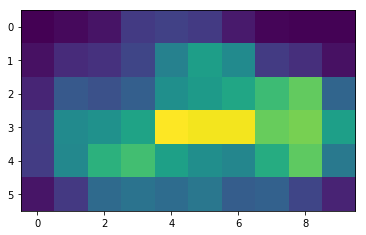

In [73]:
plt.imshow(attention_weights[3,:,:].detach().numpy())

In [74]:
lstm_step = nn.LSTMCell(input_size=128*2,hidden_size=128)

In [79]:
hiddens = []
h0, c0 = init_hidden_state(image_f)    

In [ ]:
max_seq_length = 33 

T,B,E = embedded.shape
h = h0
c = c0
for t in range(T):
    lstm_step(h,c)